# Natural Language Processing - Text Classification example

###### Links: [News dataset (Kaggle)](https://www.kaggle.com/rmisra/news-category-dataset)  |  [Article 1 (TowardsDataScience)](https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d) |  [Article 2 (TowardsDataScience)](https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794) | [Article 3 (TowardsDataScience)](https://towardsdatascience.com/text-classification-with-no-model-training-935fe0e42180)

### 0 - Setup

###### Import pckgs

In [1]:
import warnings
warnings.filterwarnings("ignore")
from nlp_utils import *

2021-12-09 16:21:01.559595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-09 16:21:01.559653: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

###### Import data

In [2]:
import json
import pandas as pd

lst_dics = []
with open('data/data_news.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
    
lst_dics[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [3]:
dtf = pd.DataFrame(lst_dics)
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH']) ][["category","headline"]]
dtf = dtf.rename(columns={"category":"y", "headline":"text"})

In [4]:
dtf.sample(5)

,y,text
57072,POLITICS,Trump Supporters Attacked By Protestors Outsid...
60917,POLITICS,Media Goes Gaga After Trump Takes A Night Off ...
81874,POLITICS,T-Shirt Mocks Scandal-Ridden Legislators Who S...
29601,POLITICS,"Trump, Syria, And The Basics Of Strategy"
105453,POLITICS,Welcome to the Anthropocene: Anthropology and ...


In [5]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50879 entries, 1 to 200848
Data columns (total 2 columns):
y       50879 non-null object
text    50879 non-null object
dtypes: object(2)
memory usage: 1.2+ MB


### 1 - Text Analysis

###### Look for Metadata
- Language detection
- Named-entities recognition
- Text cleaning
- Length analysis
- Sentiment analysis
- Word frequency

###### Target Variable

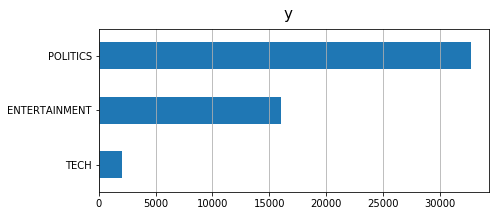

In [6]:
plot_distributions(dtf, x="y", top=None, figsize=(7,3))

In [7]:
# Imbalanced

###### Language Detection

In [8]:
# this takes a while
dtf = add_detect_lang(dtf, "text")
dtf.head()

,y,text,lang
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en


In [9]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ", dtf["lang"].iloc[i])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  -->  en


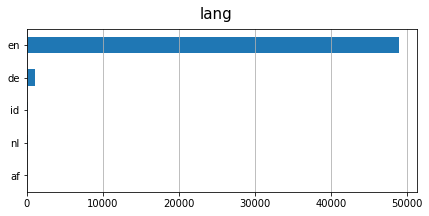

In [10]:
plot_distributions(dtf, x="lang", top=5, figsize=(7,3), max_cat=200)

In [11]:
# filter english only
dtf = dtf[dtf["lang"]=="en"]

###### Named-Entity Recognition

In [12]:
!python -m spacy download en_core_web_lg  
#ner = spacy.load("en_core_web_lg")

import en_core_web_sm
ner = en_core_web_sm.load()

The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 827.9 MB 12.1 MB/s eta 0:00:016     |██████████████                  | 360.9 MB 6.0 MB/s eta 0:01:19     |█████████████████████████▉      | 667.5 MB 40.5 MB/s eta 0:00:04     |█████████████████████████▉      | 668.7 MB 40.5 MB/s eta 0:00:04     |███████████████████████████▉    | 719.3 MB 24.7 MB/s eta 0:00:05
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [13]:
lst_tag_type = ["ORG","PERSON","NORP","GPE","LOC","FAC","EVENT","PRODUCT","WORK_OF_ART"]

In [14]:
ner_displacy(dtf["text"].iloc[0], ner, lst_tag_type, title="NER example")

In [15]:
# example of replacing text and tags extraction
utils_ner_text(dtf["text"].iloc[0], ner, lst_tag_type, grams_join="_")

("Will_Smith Joins Diplo And Nicky_Jam For The_2018 World_Cup's Official Song",
 [('Will Smith', 'PERSON'),
  ('Nicky Jam', 'PERSON'),
  ('The 2018', 'EVENT'),
  ("World Cup's", 'EVENT')])

In [16]:
# this takes a while
dtf = add_ner_spacy(dtf, "text", ner, lst_tag_type, grams_join="_", create_features=True)
dtf.head()

--- tagging ---
--- counting tags ---
--- creating features ---


,y,text,lang,text_tagged,tags,tags_GPE,tags_FAC,tags_EVENT,tags_LOC,tags_NORP,tags_ORG,tags_PERSON,tags_PRODUCT,tags_WORK_OF_ART
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Nicky Jam',...",0,0,2,0,0,0,2,0,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant Marries For The First Time At Age 57,"[{('Hugh Grant', 'PERSON'): 1}]",0,0,0,0,0,0,1,0,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato'_Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Castrato' A...",1,0,0,0,1,0,1,0,1
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna Margulies Uses Donald Trump Poop Bags...,[],0,0,0,0,0,0,0,0,0
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,1,0,0,0


In [17]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ")
print(dtf["text_tagged"].iloc[i])
print("tags:")
dtf["tags"].iloc[i]

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  --> 
Will_Smith Joins Diplo And Nicky_Jam For The_2018 World_Cup's Official Song
tags:


[{('Will Smith', 'PERSON'): 1},
 {('Nicky Jam', 'PERSON'): 1},
 {('The 2018', 'EVENT'): 1},
 {("World Cup's", 'EVENT'): 1}]

# ENTERTAINMENT:


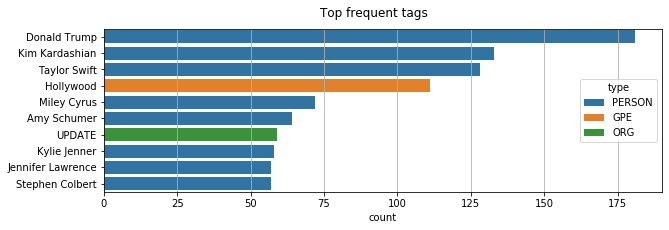

# POLITICS:


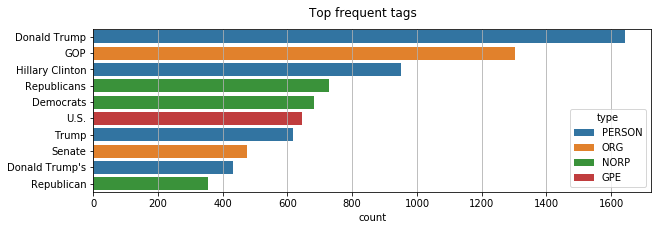

# TECH:


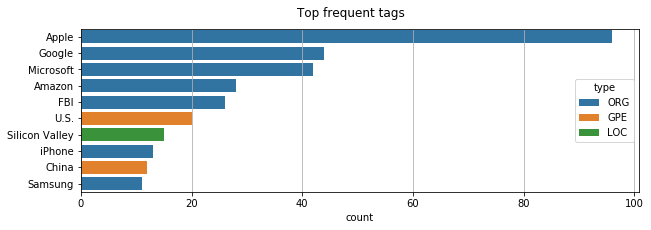

In [18]:
for y in dtf["y"].unique():
    print("# {}:".format(y))
    common_tags = tags_freq(tags=dtf[dtf["y"]==y]["tags"], top=10, figsize=(10,3))

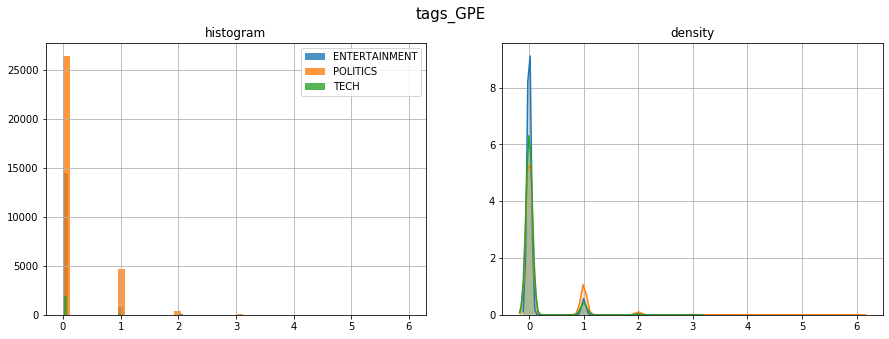

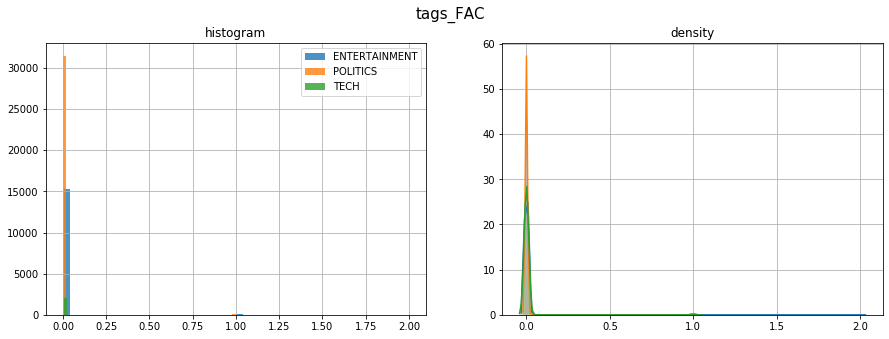

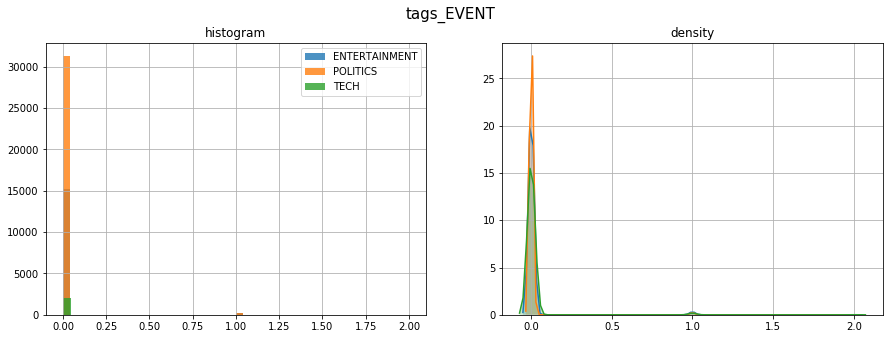

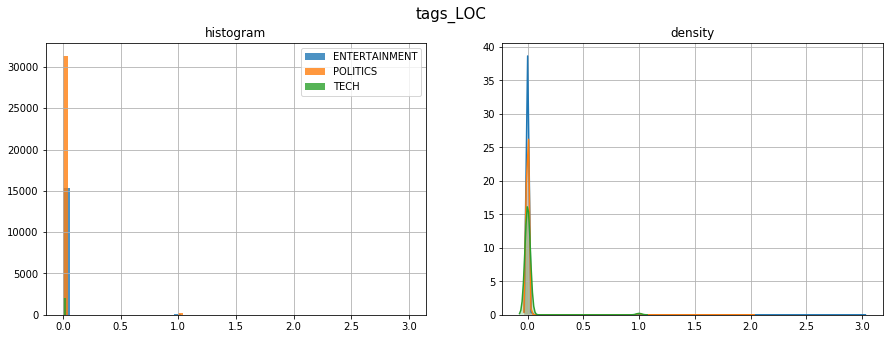

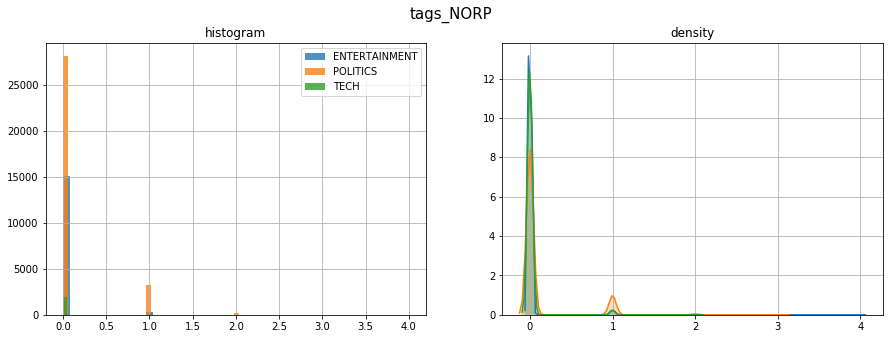

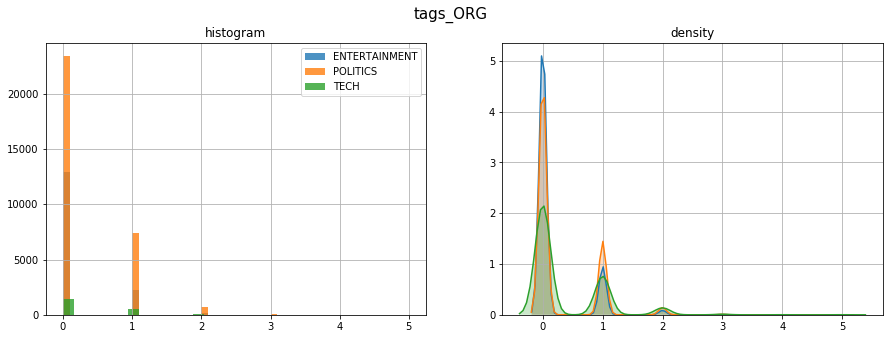

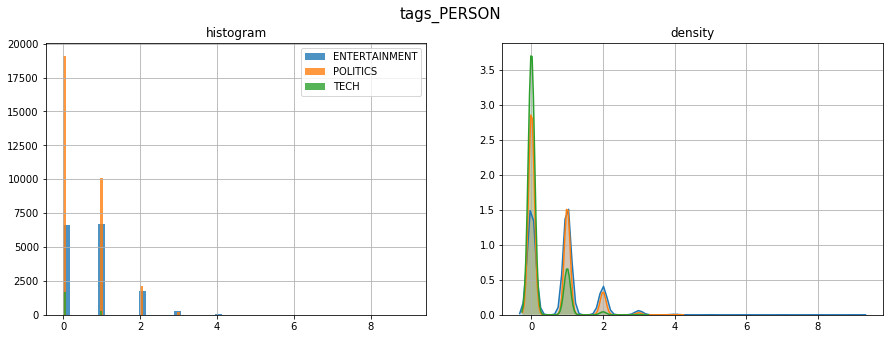

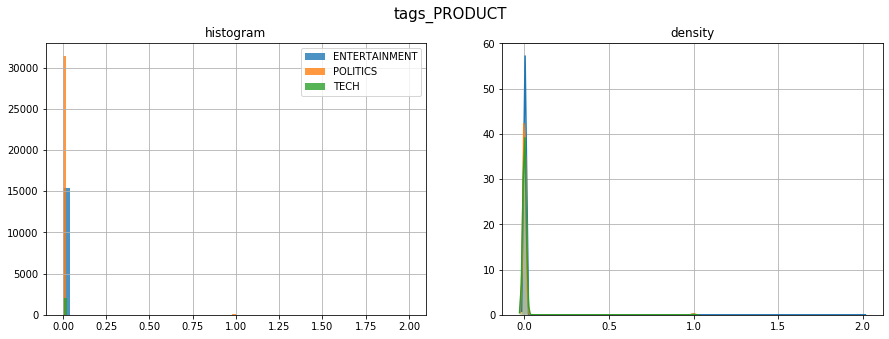

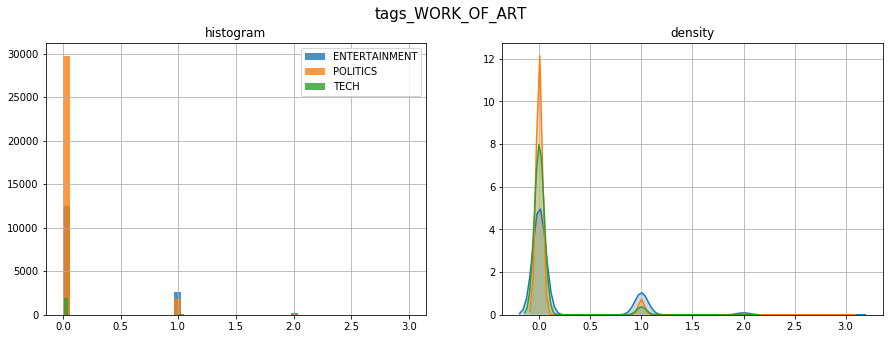

In [19]:
# tags bivariate distribution
for x in dtf.filter(like="tags_", axis=1).columns:
    plot_distributions(dtf, x=x, y="y", bins=None, figsize=(15,5))

###### Text Cleaning

In [20]:
# example
i = 0
print("--- original ---")
print(dtf["text"].iloc[i])

print("--- cleaning ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=None, stemm=False, lemm=True))

print("--- tokenization ---")
print(dtf["text"].iloc[i].split())

print("--- remove stopwords ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=nltk.corpus.stopwords.words("english"), 
                      stemm=False, lemm=None))

print("--- stemming ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=nltk.corpus.stopwords.words("english"), 
                      stemm=True, lemm=False))

print("--- lemmatisation ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=nltk.corpus.stopwords.words("english"), 
                      stemm=False, lemm=True))

--- original ---
Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song
--- cleaning ---
will smith join diplo and nicky jam for the 2018 world cup official song
--- tokenization ---
['Will', 'Smith', 'Joins', 'Diplo', 'And', 'Nicky', 'Jam', 'For', 'The', '2018', 'World', "Cup's", 'Official', 'Song']
--- remove stopwords ---
smith joins diplo nicky jam 2018 world cups official song
--- stemming ---
smith join diplo nicki jam 2018 world cup offici song
--- lemmatisation ---
smith join diplo nicky jam 2018 world cup official song


In [21]:
# create stopwords
lst_stopwords = create_stopwords(["english"], 
                                 lst_add_words=["dtype","say","new","length","object","u","ha","wa"],
                                 lst_keep_words=["new"])
lst_stopwords

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'dtype',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'ha',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'length',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'object',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'say',
 'shan',
 "shan't",
 'she',
 "she's",
 'should',
 "should've",
 'shouldn',
 "shouldn't",
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 "that'll",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'too',
 'u',
 'under',
 'until',
 'up',
 've',
 'very',
 'wa',
 'was',
 'wasn',
 "wasn't",
 'we',
 'were',
 'weren',
 "weren't",
 'what',
 'when',
 'where',
 'which',
 'while',
 'who',
 'whom',
 'why',
 'will',
 'with',
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'y',
 'you',
 "you'd",
 "you'll",
 "you're",
 "you've",
 'your',
 'yours',
 'yourself',
 'yourselves']

In [22]:
# preprocess text
dtf = add_preprocessed_text(dtf, "text", lst_regex=None, lst_stopwords=lst_stopwords, stemm=False, lemm=True)
dtf.head()

,y,text,lang,text_tagged,tags,tags_GPE,tags_FAC,tags_EVENT,tags_LOC,tags_NORP,tags_ORG,tags_PERSON,tags_PRODUCT,tags_WORK_OF_ART,text_clean
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Nicky Jam',...",0,0,2,0,0,0,2,0,0,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant Marries For The First Time At Age 57,"[{('Hugh Grant', 'PERSON'): 1}]",0,0,0,0,0,0,1,0,0,Hugh Grant Marries For The First Time At Age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato'_Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Castrato' A...",1,0,0,0,1,0,1,0,1,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna Margulies Uses Donald Trump Poop Bags...,[],0,0,0,0,0,0,0,0,0,Julianna Margulies Uses Donald Trump Poop Bags...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,1,0,0,0,Morgan Freeman 'Devastated' That Sexual Harass...


In [23]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ")
print(dtf["text_clean"].iloc[i])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  --> 
Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song


###### Length Analysis

In [24]:
dtf = add_text_length(dtf, "text_clean")
dtf.head()

                       min       mean     max
char_count           6.000  54.356372  242.00
word_count           1.000  11.384628   56.00
sentence_count       1.000   1.039288    5.00
avg_word_length      1.875   4.892794   13.75
avg_sentence_lenght  1.000  11.104573   56.00


,y,text,lang,text_tagged,tags,tags_GPE,tags_FAC,tags_EVENT,tags_LOC,tags_NORP,tags_ORG,tags_PERSON,tags_PRODUCT,tags_WORK_OF_ART,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Nicky Jam',...",0,0,2,0,0,0,2,0,0,Will Smith Joins Diplo And Nicky Jam For The 2...,15,62,1,4.133333,15.0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant Marries For The First Time At Age 57,"[{('Hugh Grant', 'PERSON'): 1}]",0,0,0,0,0,0,1,0,0,Hugh Grant Marries For The First Time At Age 57,10,38,1,3.800000,10.0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato'_Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Castrato' A...",1,0,0,0,1,0,1,0,1,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,12,59,1,4.916667,12.0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna Margulies Uses Donald Trump Poop Bags...,[],0,0,0,0,0,0,0,0,0,Julianna Margulies Uses Donald Trump Poop Bags...,13,59,1,4.538462,13.0
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,1,0,0,0,Morgan Freeman 'Devastated' That Sexual Harass...,11,71,1,6.454545,11.0


In [25]:
# check
i = 0
print(dtf["text_clean"].iloc[i], " --> ")
for col in ["word_count","char_count","sentence_count","avg_word_length","avg_sentence_lenght"]:
    print(col+":", dtf[col].iloc[i])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  --> 
word_count: 15
char_count: 62
sentence_count: 1
avg_word_length: 4.133333333333334
avg_sentence_lenght: 15.0


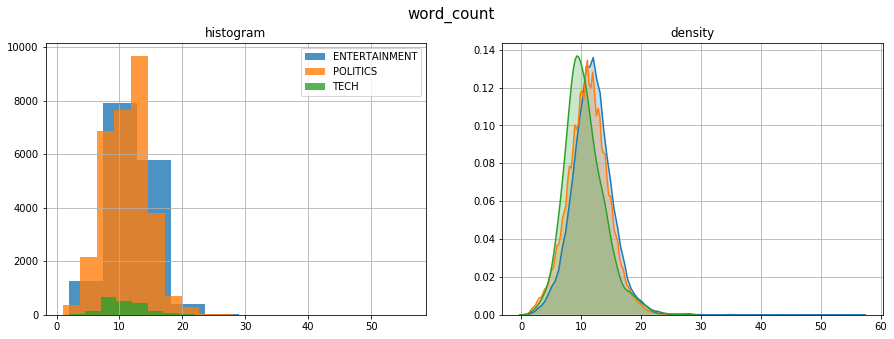

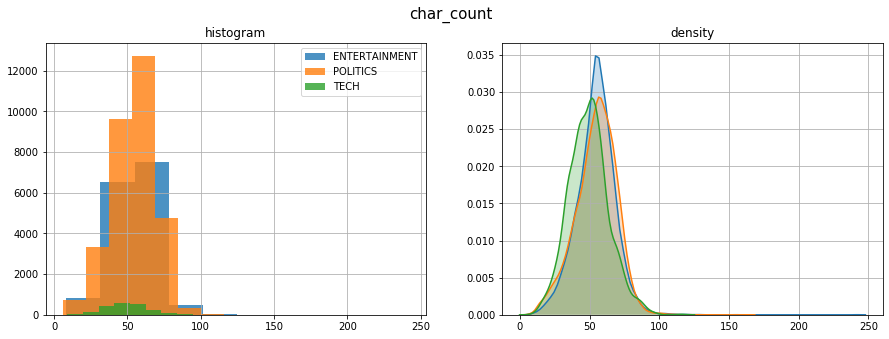

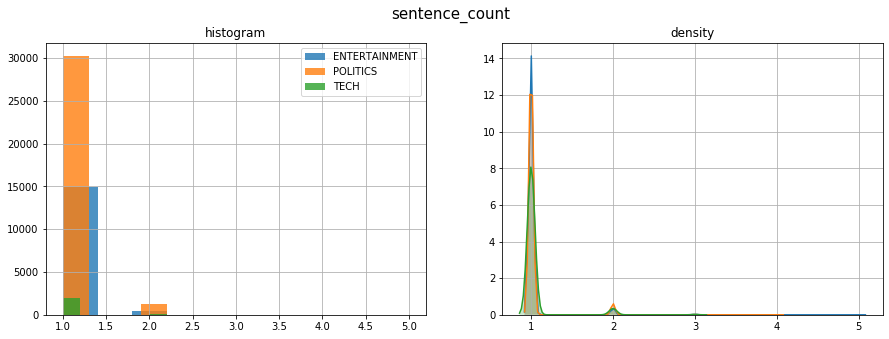

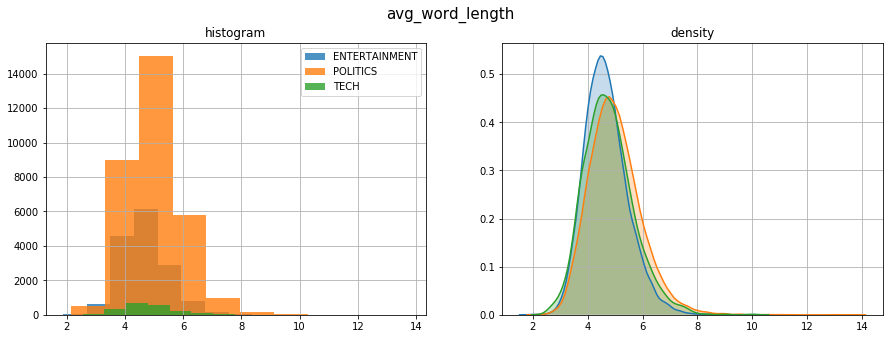

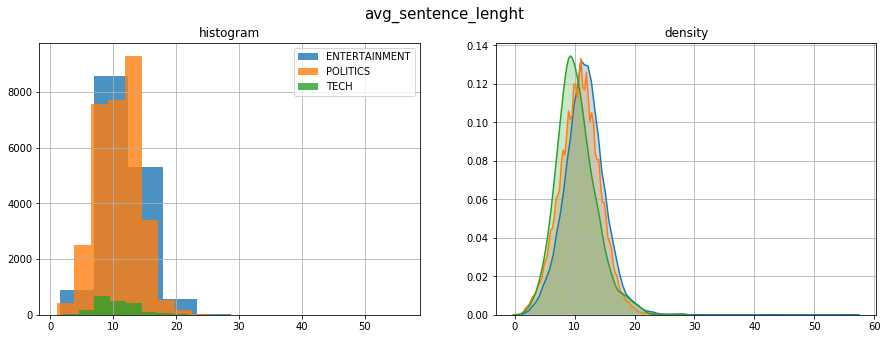

In [26]:
for col in ["word_count","char_count","sentence_count","avg_word_length","avg_sentence_lenght"]:
    plot_distributions(dtf, x=col, y="y", bins=10, figsize=(15,5))

###### Sentiment Analysis

In [27]:
dtf = add_sentiment(dtf, "text_clean", algo="textblob", sentiment_range=(-1,1))
dtf.head()

             count      mean       std  min  25%  50%    75%  max
sentiment  48946.0  0.049639  0.257571 -1.0  0.0  0.0  0.125  1.0


,y,text,lang,text_tagged,tags,tags_GPE,tags_FAC,tags_EVENT,tags_LOC,tags_NORP,...,tags_PERSON,tags_PRODUCT,tags_WORK_OF_ART,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Nicky Jam',...",0,0,2,0,0,...,2,0,0,Will Smith Joins Diplo And Nicky Jam For The 2...,15,62,1,4.133333,15.0,0.000000
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant Marries For The First Time At Age 57,"[{('Hugh Grant', 'PERSON'): 1}]",0,0,0,0,0,...,1,0,0,Hugh Grant Marries For The First Time At Age 57,10,38,1,3.800000,10.0,0.250000
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato'_Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Castrato' A...",1,0,0,0,1,...,1,0,1,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,12,59,1,4.916667,12.0,0.136364
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna Margulies Uses Donald Trump Poop Bags...,[],0,0,0,0,0,...,0,0,0,Julianna Margulies Uses Donald Trump Poop Bags...,13,59,1,4.538462,13.0,0.000000
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,...,0,0,0,Morgan Freeman 'Devastated' That Sexual Harass...,11,71,1,6.454545,11.0,0.500000


In [28]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ", dtf["sentiment"].iloc[i])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  -->  0.0


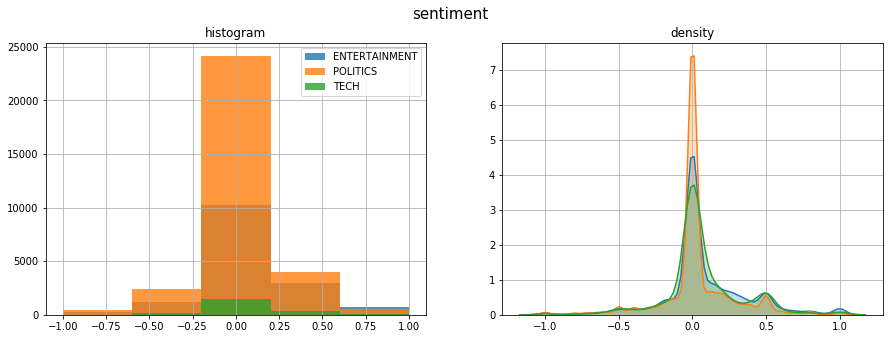

In [29]:
plot_distributions(dtf, x="sentiment", y="y", bins=5, figsize=(15,5))

In [30]:
# I'll give a range of 0-1 to the sentiment
dtf = add_sentiment(dtf, "text_clean", algo="textblob", sentiment_range=(0,1))

             count      mean       std  min  25%  50%     75%  max
sentiment  48946.0  0.524819  0.128785  0.0  0.5  0.5  0.5625  1.0


###### Word frequency

# ENTERTAINMENT:


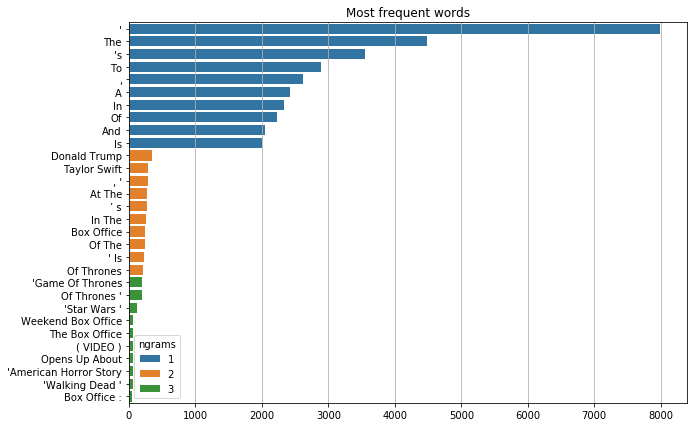

# POLITICS:


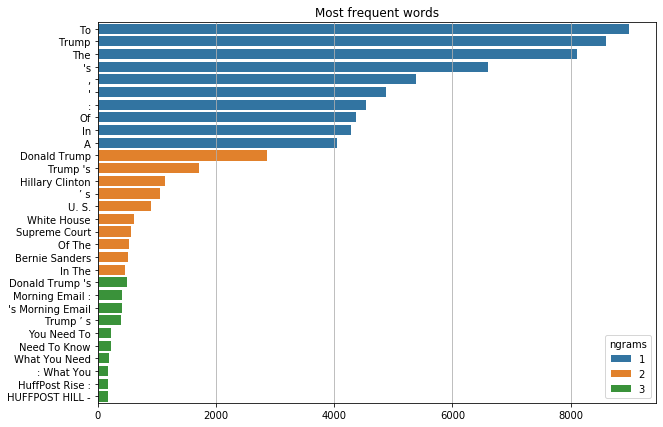

# TECH:


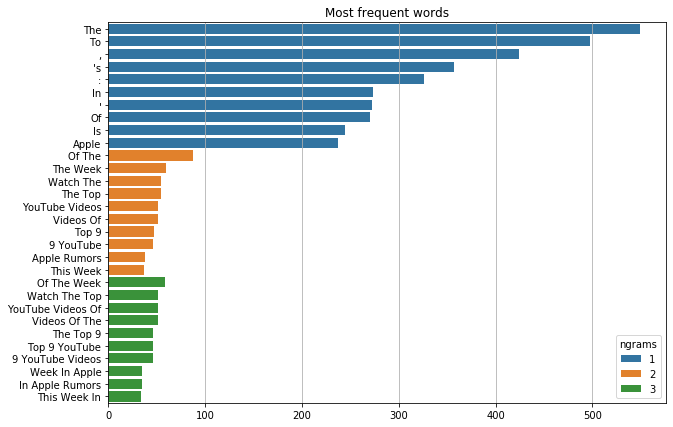

In [31]:
dtf_freq = pd.DataFrame()
for y in dtf["y"].unique():
    print("# {}:".format(y))
    dtf_y = word_freq(corpus=dtf[dtf["y"]==y]["text_clean"], ngrams=[1,2,3], top=10, figsize=(10,7))
    dtf_y["y"] = y
    dtf_freq = dtf_freq.append(dtf_y)

In [32]:
dtf_freq.sample(5)

,word,freq,ngrams,y
14711,As Mueller,3,2,POLITICS
263802,Movement Into The,1,3,POLITICS
183560,Gets Its Night,1,3,POLITICS
28830,Spacey Replacement Christopher,1,3,ENTERTAINMENT
82881,Breath During First,1,3,ENTERTAINMENT


# ENTERTAINMENT:


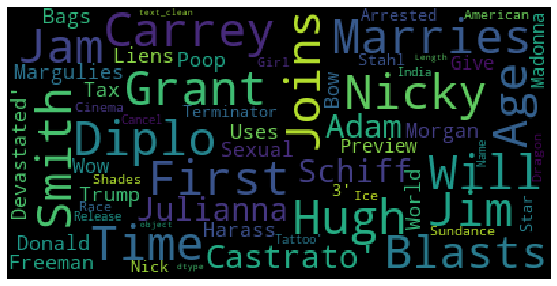

# POLITICS:


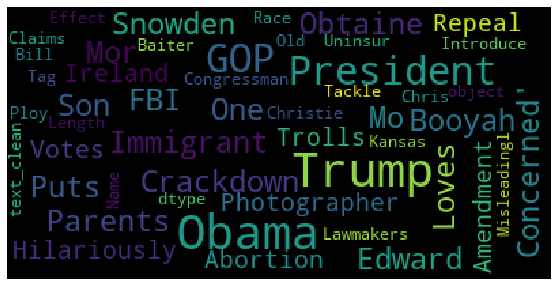

# TECH:


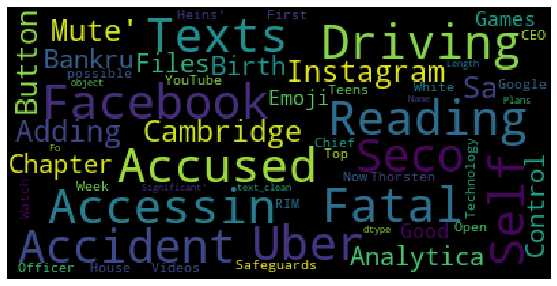

In [33]:
for y in dtf["y"].unique():
    print("# {}:".format(y))
    plot_wordcloud(corpus=dtf[dtf["y"]==y]["text_clean"], max_words=150, max_font_size=35, figsize=(10,5))

In [34]:
# add specific words as features
dtf = add_word_freq(dtf, "text_clean", lst_words=["new york","new","york"], freq="count")
dtf.head()

found records:
['new york: 0', 'new: 125', 'york: 0']


,y,text,lang,text_tagged,tags,tags_GPE,tags_FAC,tags_EVENT,tags_LOC,tags_NORP,...,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment,new york,new,york
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Nicky Jam',...",0,0,2,0,0,...,Will Smith Joins Diplo And Nicky Jam For The 2...,15,62,1,4.133333,15.0,0.500000,0.0,0.0,0.0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant Marries For The First Time At Age 57,"[{('Hugh Grant', 'PERSON'): 1}]",0,0,0,0,0,...,Hugh Grant Marries For The First Time At Age 57,10,38,1,3.800000,10.0,0.625000,0.0,1.0,0.0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato'_Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Castrato' A...",1,0,0,0,1,...,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,12,59,1,4.916667,12.0,0.568182,0.0,0.0,0.0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna Margulies Uses Donald Trump Poop Bags...,[],0,0,0,0,0,...,Julianna Margulies Uses Donald Trump Poop Bags...,13,59,1,4.538462,13.0,0.500000,0.0,0.0,0.0
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,...,Morgan Freeman 'Devastated' That Sexual Harass...,11,71,1,6.454545,11.0,0.750000,0.0,1.0,0.0


###### Summary

In [35]:
# keeping all the features
dtf.head()

,y,text,lang,text_tagged,tags,tags_GPE,tags_FAC,tags_EVENT,tags_LOC,tags_NORP,...,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment,new york,new,york
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Nicky Jam',...",0,0,2,0,0,...,Will Smith Joins Diplo And Nicky Jam For The 2...,15,62,1,4.133333,15.0,0.500000,0.0,0.0,0.0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant Marries For The First Time At Age 57,"[{('Hugh Grant', 'PERSON'): 1}]",0,0,0,0,0,...,Hugh Grant Marries For The First Time At Age 57,10,38,1,3.800000,10.0,0.625000,0.0,1.0,0.0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato'_Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Castrato' A...",1,0,0,0,1,...,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,12,59,1,4.916667,12.0,0.568182,0.0,0.0,0.0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna Margulies Uses Donald Trump Poop Bags...,[],0,0,0,0,0,...,Julianna Margulies Uses Donald Trump Poop Bags...,13,59,1,4.538462,13.0,0.500000,0.0,0.0,0.0
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,...,Morgan Freeman 'Devastated' That Sexual Harass...,11,71,1,6.454545,11.0,0.750000,0.0,1.0,0.0


### 2 - Preprocessing

###### Encode Target

In [36]:
# not necessary
dtf, dic_y_mapping = add_encode_variable(dtf, "y")

print(dic_y_mapping)
dtf[["y","y_id"]].sample(5)

{0: 'ENTERTAINMENT', 1: 'POLITICS', 2: 'TECH'}


,y,y_id
17897,POLITICS,1
262,POLITICS,1
20280,POLITICS,1
107264,ENTERTAINMENT,0
114098,POLITICS,1


###### Partitioning

In [37]:
dtf_train, dtf_test = dtf_partitioning(dtf, y="y", test_size=0.3, shuffle=False)

X_train shape: (34262, 24) | X_test shape: (14684, 24)
y:
  POLITICS  -->  train: 0.71 | test: 0.49
  ENTERTAINMENT  -->  train: 0.26 | test: 0.44
  TECH  -->  train: 0.03 | test: 0.07
25 features: ['text', 'lang', 'text_tagged', 'tags', 'tags_GPE', 'tags_FAC', 'tags_EVENT', 'tags_LOC', 'tags_NORP', 'tags_ORG', 'tags_PERSON', 'tags_PRODUCT', 'tags_WORK_OF_ART', 'text_clean', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 'avg_sentence_lenght', 'sentiment', 'new york', 'new', 'york', 'y_id']


In [38]:
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

### 3 - Baseline (Bag-of-Words + Machine Learning)

###### Plan:
- Features Engineering with vectorizer
- Features Selection by p-value
- Model Design
- Train / Test
- Evaluate
- Explainability

###### Features Engineering

In [39]:
# Count (classic BoW)
#vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False)

# Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False)

--- creating sparse matrix ---
shape: (34262, 10000)
--- creating vocabulary ---
10000 words
--- tokenization ---
34262 texts


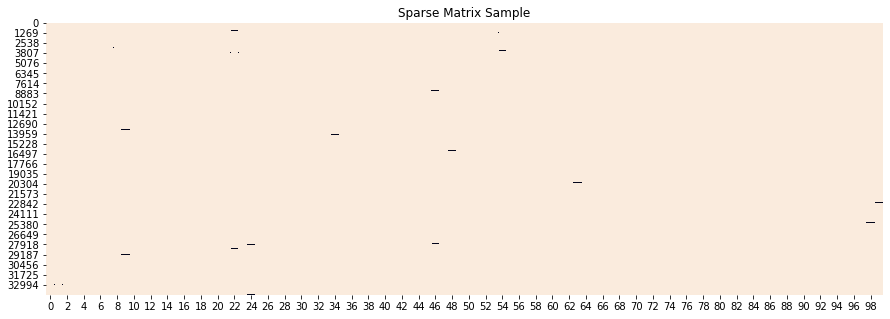

In [40]:
dic_bow = fit_bow(corpus=dtf_train["text_clean"], vectorizer=vectorizer, vocabulary=None)

X_train, X_names, vectorizer, dic_vocabulary, lst_text2tokens = dic_bow["X"], dic_bow["X_names"], dic_bow["vectorizer"], dic_bow["dic_vocabulary"], dic_bow["lst_text2tokens"]

In [41]:
# check some features
f_range = (500, 505)

print("fetures name (from dic_vocabulary):")
print({k:v for k,v in sorted(dic_vocabulary.items(), key=lambda item:item[1], reverse=False)
      if v in np.arange(f_range[0], f_range[1]+1, step=1)})

print("")
print("value of these features (in the sparse matrix) for the first text:")
print(vectorizer.get_feature_names()[f_range[0]:f_range[1]])
print(X_train[0, f_range[0]:f_range[1]].todense())

fetures name (from dic_vocabulary):
{'Answers': 500, 'Anthem': 501, 'Anthony': 502, 'Anthony Scaramucci': 503, 'Anthony Weiner': 504, 'Anti': 505}

value of these features (in the sparse matrix) for the first text:
['Answers', 'Anthem', 'Anthony', 'Anthony Scaramucci', 'Anthony Weiner']
[[0. 0. 0. 0. 0.]]


In [42]:
# check text conversion
i = 0

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## list of token ids: [[1, 2, 3], ...]
len_tokens = len(lst_text2tokens[i])
print("to: ", lst_text2tokens[i], "| len:", len(lst_text2tokens[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

## words not in vocabulary?
if len_txt-len_tokens != 0:
    missing_words = [word for word in dtf_train["text_clean"].iloc[i].split() if word not in dic_vocabulary.keys()]
    print("!!!", len_txt-len_tokens, "words not in vocabulary:", missing_words)

from:  Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song | len: 14
to:  [9712, 7630, 4473, 411, 4379, 2977, 8217, 38, 9861, 5849, 7683] | len: 11
check:  Will  -- idx in vocabulary --> 9712
!!! 3 words not in vocabulary: ['Diplo', 'Nicky', "Cup's"]


###### Features Selection

In [43]:
X_names, dtf_selection = features_selection(X_train, dtf_train["y"], X_names, top=None, print_top=10)

features selection: from 10,000 to 2,931
 
# ENTERTAINMENT:
  . selected features: 2472
  . top features: Actor, Awards, Baby, Beyoncé, Box Office, Clinton, Dead, Dead At, Donald, Donald Trump
 
# POLITICS:
  . selected features: 2561
  . top features: Apple, Awards, Clinton, Dead, Dead At, Donald, Donald Trump, GOP, Game, Game Of
 
# TECH:
  . selected features: 358
  . top features: Amazon, Android, App, Apple, Apps, Black Friday, Cars, Cyber, Data, Deals
 


In [44]:
dtf_selection.sample(0)

,feature,score,y


--- creating sparse matrix ---
shape: (34262, 2931)
--- used vocabulary ---
2931 words
--- tokenization ---
34262 texts


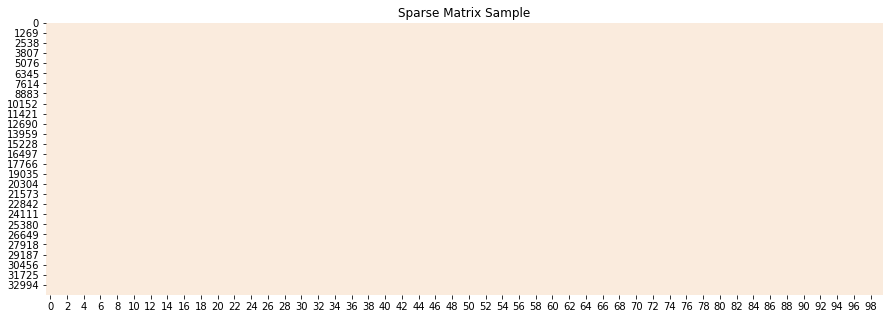

In [45]:
# Recreate Vectorizer with the selected vocabulary
dic_bow = fit_bow(corpus=dtf_train["text_clean"], vocabulary=X_names)

X_train, X_names, vectorizer, dic_vocabulary, lst_text2tokens = dic_bow["X"], dic_bow["X_names"], dic_bow["vectorizer"], dic_bow["dic_vocabulary"], dic_bow["lst_text2tokens"]

In [46]:
# Explore the sparse matrix as dtf
dtf_X_train = sparse2dtf(X_train, dic_vocabulary, X_names, prefix="")

In [47]:
dtf_X_train = pd.concat([dtf_train[["text","y"]], dtf_X_train.set_index(dtf_train.index)], axis=1)
dtf_X_train.head()

,text,y,Actor,Awards,Baby,Beyoncé,Box Office,Clinton,Dead,Dead At,...,Auto,Link,If You,People With,Lives,Text,Fees,Shopping,It Will,Careful
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Hugh Grant Marries For The First Time At Age 57,ENTERTAINMENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Morgan Freeman 'Devastated' That Sexual Harass...,ENTERTAINMENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###### Model Design

In [48]:
classifier = naive_bayes.MultinomialNB()

###### Train / Test

In [49]:
# Take the raw text for X_test and will be transformed/predicted by the pipeline
X_test = dtf_test["text_clean"].values

In [50]:
model, predicted_prob, predicted = fit_ml_classif(X_train, y_train, X_test, vectorizer, classifier)

###### Evaluate

Accuracy: 0.49
Auc: 0.5
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       1.00      0.00      0.00      6444
     POLITICS       0.49      1.00      0.66      7176
         TECH       0.00      0.00      0.00      1064

     accuracy                           0.49     14684
    macro avg       0.50      0.33      0.22     14684
 weighted avg       0.68      0.49      0.32     14684



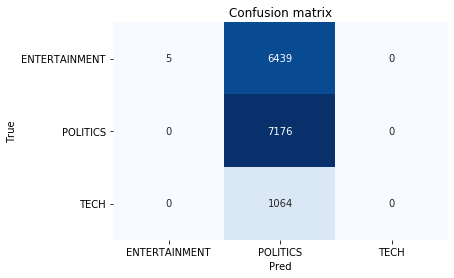

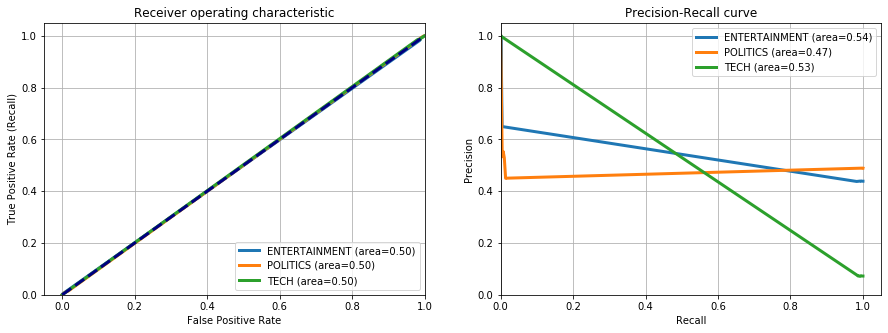

In [51]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

###### Explainability

In [52]:
i = 9
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
print(" ")
exp = explainer_lime(model, y_train, txt_instance=dtf_test["text"].iloc[i], top=3)

True: ENTERTAINMENT --> Pred: POLITICS | Prob: 0.71
 


### 4 - Model Desing & Testing (Embedding + Deep Learning)

###### Plan:
- Create common n-grams detectors
- Features Engineering with sequence padding
- Load/Train NLP
- Create Weights with word embedding
- Model Design
- Train / Test
- Evaluate
- Explainability

###### Common n-grams detectors

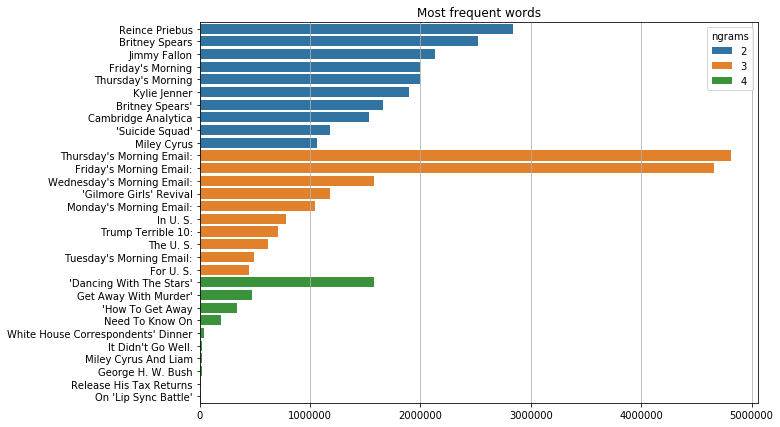

In [53]:
# not necessary, but useful
lst_common_terms = ["of","with","without","and","or","the","a"]

lst_ngrams_detectors, dtf_ngrams = create_ngrams_detectors(corpus=dtf_train["text_clean"], 
                                                           lst_common_terms=lst_common_terms, 
                                                           min_count=5, 
                                                           top=10, 
                                                           figsize=(10,7))

In [54]:
txt = "donald trump is on saturday night live from new york"
lst_ngrams_detectors[1][txt.split()]

['donald',
 'trump',
 'is',
 'on',
 'saturday',
 'night',
 'live',
 'from',
 'new',
 'york']

In [55]:
dtf_ngrams.sample(3)

,word,freq,ngrams
2771,100 Days,251.832979,2
1513,Refusing To,251.565356,2
2425,Supreme Court's,118361.500000,2


###### Features Engineering

--- tokenization ---
38812 words
--- padding to sequence ---
34262 sequences of length 15


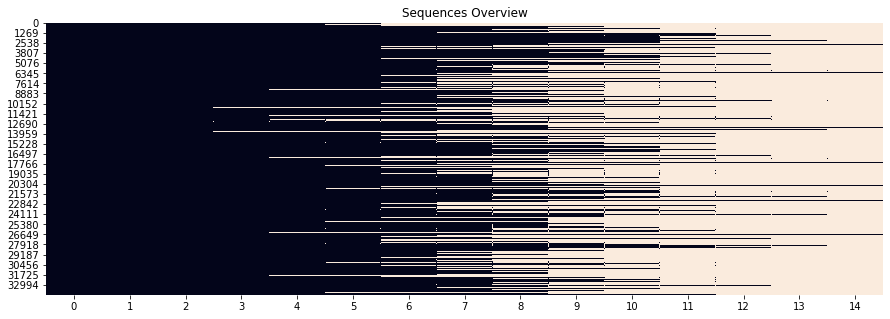

In [56]:
# create input for lstm (sequences of tokens)
dic_seq = text2seq(corpus=dtf_train["text_clean"], lst_ngrams_detectors=lst_ngrams_detectors, 
                   top=None, oov="NaN", maxlen=15)

X_train, tokenizer, dic_vocabulary = dic_seq["X"], dic_seq["tokenizer"], dic_seq["dic_vocabulary"]

In [57]:
# check text conversion
i = 0

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song | len: 14
to:  [ 1897   695 11136    10 11137  6223     6     2   503   415 18938   251
   782     0     0] | len: 15
check:  Will  -- idx in vocabulary --> 30
vocabulary:  {'NaN': 1, 'The': 2, 'To': 3, 'In': 4, 'A': 5} ... (padding element, 0)


--- tokenization ---
--- padding to sequence ---
14684 sequences of length 15


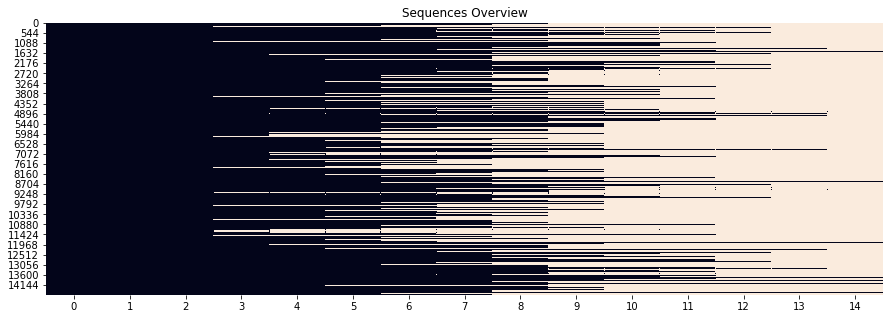

In [58]:
# Preprocess Test with the same tokenizer
X_test = text2seq(corpus=dtf_test["text_clean"], lst_ngrams_detectors=lst_ngrams_detectors,
                  fitted_tokenizer=tokenizer, maxlen=X_train.shape[1])

###### Load/Train NLP

In [59]:
# Load pre-trained W2V
#nlp = gensim_api.load("glove-wiki-gigaword-300")

In [60]:
# Or train Word2Vec from scratch
avg_len = np.max([len(text.split()) for text in dtf_train["text_clean"]]) /2 

lst_corpus, nlp = fit_w2v(corpus=dtf_train["text_clean"], lst_ngrams_detectors=lst_ngrams_detectors,
                          min_count=1, size=300, window=avg_len, sg=0, epochs=30)

In [61]:
nlp

In [62]:
# check nlp model
word = "Open Letter"
nlp[word].shape

(300,)

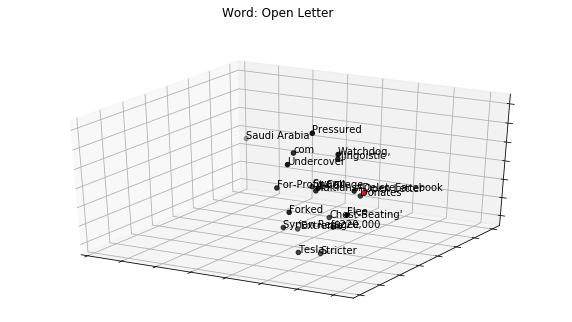

In [63]:
#%matplotlib notebook
plot_w2v(lst_words=[word], nlp=nlp, plot_type="3d", top=20, figsize=(10,5))

In [64]:
#plot_w2v(lst_words=None, nlp=nlp, plot_type="2d", annotate=False, figsize=(20,10))

###### Create Weights

In [65]:
embeddings = vocabulary_embeddings(dic_vocabulary, nlp)

vocabulary mapped to 38813 vectors of size 300


In [66]:
# check
word = dtf_train["text_clean"].iloc[0].split()[0]
print("word:", word)
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, "|vector")

word: Will
dic[word]: 30 |idx
embeddings[idx]: (300,) |vector


In [67]:
# padding element
print("null vector:", 0)
embeddings[0]

null vector: 0


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

###### Model Design

In [68]:
'''
Dot-Product Attention layer for DL models.
    softmax(Q x K) x V
:parameter
    :param x: tensor
    :param neurons: int - length of the sequences (X_train.shape[1])
'''
def attention_layer(x, neurons):
    Q, K, V = x, x, x
    K = layers.Permute((2,1))(K)
    QxK = layers.Dense(neurons, activation="softmax")(K)
    QxK = layers.Permute((2,1), name="attention")(QxK)
    x = layers.multiply([V, QxK])
    return x

In [69]:
# Embedding network with Bi-LSTM and Attention layers (for attention explainer)

x_in = layers.Input(shape=(X_train.shape[1],))

## embedding
x = layers.Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], weights=[embeddings],
                     input_length=X_train.shape[1], trainable=False)(x_in)

## attention
#x = attention_layer(x, neurons=X_train.shape[1])  #<-- tensorflow 1 (manual function)
x = layers.Attention()([x,x])                      #<-- tensorflow 2 (included in keras)

## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=X_train.shape[1], dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=X_train.shape[1], dropout=0.2))(x)

## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(units=len(np.unique(y_train)), activation='softmax')(x)

## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

2021-12-09 16:33:39.049503: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kguttas/anaconda3/envs/practica/lib/python3.7/site-packages/cv2/../../lib64:
2021-12-09 16:33:39.049547: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-09 16:33:39.049571: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2021-12-09 16:33:39.050836: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 300)      11643900    ['input_1[0][0]']                
                                                                                                  
 attention (Attention)          (None, 15, 300)      0           ['embedding[0][0]',              
                                                                  'embedding[0][0]']              
                                                                                                  
 bidirectional (Bidirectional)  (None, 15, 30)       37920       ['attention[0][0]']          

In [70]:
# Binary version without attention (shap explainer only works with this)

#y_train = pd.get_dummies(dtf_train["y"], drop_first=False).values

#model = models.Sequential([
#    layers.Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], weights=[embeddings],
#                     input_length=X_train.shape[1], trainable=False),
#    layers.LSTM(units=X_train.shape[1], dropout=0.2),
#    layers.Dense(3, activation='sigmoid')
#])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

#training = model.fit(x=X_train, y=y_train, batch_size=256, epochs=10, shuffle=True, verbose=0, validation_split=0.3)
#utils_plot_keras_training(training)
#predicted_prob = model.predict(X_test)
#predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

###### Train / Test

{0: 'ENTERTAINMENT', 1: 'POLITICS', 2: 'TECH'}


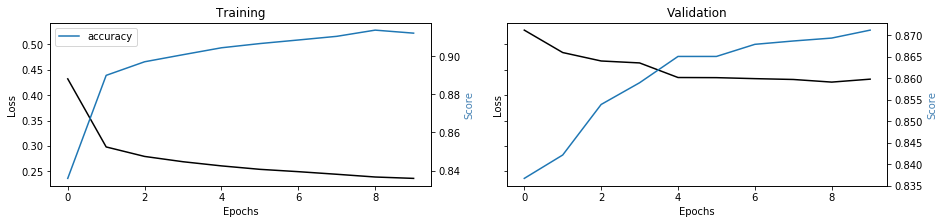

In [71]:
# this takes a while
model, predicted_prob, predicted = fit_dl_classif(X_train, y_train, X_test, encode_y=True, 
                                                  model=model, epochs=10, batch_size=256)

###### Evaluate

Accuracy: 0.79
Auc: 0.87
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.89      0.74      0.80      6444
     POLITICS       0.74      0.95      0.83      7176
         TECH       0.91      0.09      0.17      1064

     accuracy                           0.79     14684
    macro avg       0.85      0.59      0.60     14684
 weighted avg       0.82      0.79      0.77     14684



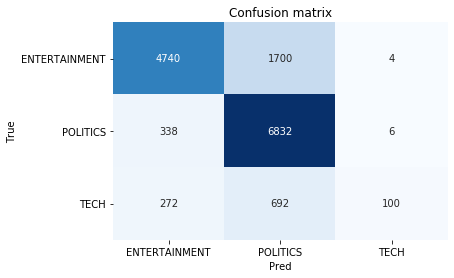

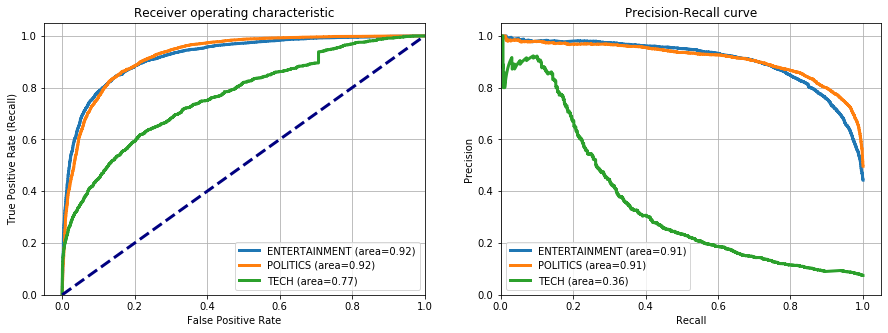

In [72]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

###### Explainability

In [73]:
i = 9
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
print(" ")
text_exp = explainer_attention(model, tokenizer, dtf_test["text"].iloc[i], lst_ngrams_detectors, top=3, figsize=(4,2))

print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text_exp))

True: ENTERTAINMENT --> Pred: ENTERTAINMENT | Prob: 0.98
 
--- No word recognized ---
Text with highlighted words


### 5 - Model Desing & Testing (Language model + Transfer Learning)

###### Plan:
- Features Engineering
- Model Design
- Train / Test
- Evaluate
- Explainability

###### Features Engineering

In [74]:
# Load pre-trained BERT tokenizer
#tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
#lst_vocabulary = list(tokenizer.vocab.keys())

In [75]:
# Load pre-trained BERT tokenizer (use a lighter veriosn: distil-BERT)
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
lst_vocabulary = list(tokenizer.vocab.keys())

2021-12-09 16:34:38.386008: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the 

In [76]:
# check nlp model
txt = "river bank"
X = embedding_bert(txt, tokenizer, nlp, log=True)
print("shape:", X.shape)
print("mean:", np.mean(X[1]))

tokens: ['[CLS]', 'river', 'bank', '[SEP]']
ids   : [101, 2314, 2924, 102]
shape: (2, 768)
mean: -0.008974844


In [77]:
X_train = tokenize_bert(corpus=dtf_train["text"], tokenizer=tokenizer, maxlen=50)

maxlen: 50
created tensor idx-masks-segments: 3x (34262, 52)


In [78]:
# check feature creation
i = 0

print("txt: ", dtf_train["text"].iloc[0])
print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i].tolist()])
print("idx: ", X_train[0][i])
print("mask: ", X_train[1][i])
print("segment: ", X_train[2][i])

txt:  Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song
tokenized: ['[CLS]', '[CLS]', 'will', 'smith', 'joins', 'dip', '##lo', 'and', 'nicky', 'jam', 'for', 'the', '2018', 'world', 'cups', 'official', 'song', '[SEP]', '[UNK]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[SEP]']
idx:  [  101   101  2097  3044  9794 16510  4135  1998 20158  9389  2005  1996
  2760  2088 10268  2880  2299   102   100     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0   102]
mask:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
segment:  [0 0 0

In [79]:
X_test = tokenize_bert(corpus=dtf_test["text"], tokenizer=tokenizer, maxlen=50)

maxlen: 50
created tensor idx-masks-segments: 3x (14684, 52)


###### Model Design

In [80]:
# Pre-trained BERT + fine-tuning (transfer learning)

## inputs
#idx = layers.Input((50), dtype="int32", name="input_idx")
#masks = layers.Input((50), dtype="int32", name="input_masks")
#segments = layers.Input((50), dtype="int32", name="input_segments")
## pre-trained bert
#bert = transformers.TFBertModel.from_pretrained("bert-base-uncased")
#bert_out, _ = bert([idx, masks, segments])
## fine-tuning
#x = layers.GlobalAveragePooling1D()(bert_out)
#x = layers.Dense(64, activation="relu")(x)
#y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)
## compile
#model = models.Model([idx, masks, segments], y_out)
#for layer in model.layers[:4]:
#    layer.trainable = False
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.summary()

In [81]:
# Pre-trained distil-BERT + fine-tuning (transfer learning)

## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")

## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]

## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)

## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  ((None, 50, 768),   66362880    ['input_idx[0][0]',              
 ilBertModel)                   )                                 'input_masks[0][0]']            
                                                                                                  
 global_average_pooling1d (Glob  (None, 768)         0           ['tf_distil_bert_model_1[0]

In [83]:
model

###### Train / Test

In [84]:
# this takes a while
model, predicted_prob, predicted = fit_bert_classif(X_train, y_train, X_test, encode_y=False, 
                                                    model=model, epochs=3, batch_size=64)

None
Epoch 1/3


ValueError: in user code:

    File "/home/kguttas/anaconda3/envs/practica/lib/python3.7/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/kguttas/anaconda3/envs/practica/lib/python3.7/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/kguttas/anaconda3/envs/practica/lib/python3.7/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/kguttas/anaconda3/envs/practica/lib/python3.7/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/home/kguttas/anaconda3/envs/practica/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/kguttas/anaconda3/envs/practica/lib/python3.7/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_2" expects 2 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 52) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 50) dtype=int32>]


###### Evaluate

In [ ]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

###### Explainability

### 6 - Model Desing & Testing (Clustering by Similarity)

###### Plan:
- Create Target Clusters: Define keywords for each class using W2V
- Features Engineering: embedding X and y with BERT
- Model Design & Testing: Assign cluster using Cosine Similarity
- Evaluate
- Explainability

######  Create Target Clusters

In [ ]:
# Load pre-trained W2V
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [ ]:
# Strategy 1) From the feature selection in BoW ...
dtf_selection.sample(3)

In [ ]:
dic_clusters = {}
for y in np.unique(y_train):
    dic_clusters[y] = [word for word in dtf_selection[dtf_selection["y"]==y]["feature"].tolist() if nlp.vocab.get(word)]

for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

In [ ]:
plot_w2v_cluster(dic_clusters, nlp, plot_type="2d", annotate=False, figsize=(20,10))

In [ ]:
#-> It's no good, they are not specific, POLITICS is pretty much everywhere.

In [ ]:
# Strategy 2) LDA for topic modeling
dtf_topics = pd.DataFrame()
for y in dtf_train["y"].unique():
    print("# {}:".format(y))
    lda, dtf_y = fit_lda(corpus=dtf_train[dtf_train["y"]==y]["text_clean"], n_topics=4, 
                         lst_ngrams_detectors=lst_ngrams_detectors, figsize=(10,10))
    dtf_y["y"] = y
    dtf_topics = dtf_topics.append(dtf_y)
    print(" ")

In [ ]:
dtf_topics.sample(5)

In [ ]:
dic_clusters = {y:dtf_topics[dtf_topics["y"]==y]["word"].values.tolist() for y in dtf_topics["y"].unique()}

for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

In [ ]:
#%matplotlib notebook
plot_w2v_cluster(dic_clusters, nlp, plot_type="3d", annotate=True, figsize=(20,10))

In [ ]:
#-> Still not good.

In [ ]:
# Strategy 3) using NLP to get smilar words from manual inputs
nlp.most_similar(["obama"], topn=3)

In [ ]:
dic_clusters = {}
dic_clusters["ENTERTAINMENT"] = get_similar_words(['celebrity','cinema','movie','music'], top=30, nlp=nlp)
dic_clusters["POLITICS"] = get_similar_words(['gop','clinton','president','obama','republican'], top=30, nlp=nlp)
dic_clusters["TECH"] = get_similar_words(['amazon','android','app','apple','facebook','google','tech'], top=30, nlp=nlp)

for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

In [ ]:
plot_w2v_cluster(dic_clusters, nlp, plot_type="2d", annotate=True, figsize=(20,10))

In [ ]:
#-> Much better, they are separated from each other.

##### Features Engineering

In [ ]:
# Load pre-trained BERT tokenizer (use a lighter veriosn: distil-BERT)
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
lst_vocabulary = list(tokenizer.vocab.keys())

In [ ]:
# Create X (Unsupervised, so no need to use dtf_train)
X_test = embedding_bert(dtf_test["text_clean"], tokenizer, nlp)
X_test.shape

In [ ]:
# Create y as {label:mean_vector}
dic_y = {k:embedding_bert(v, tokenizer, nlp).mean(0) for k,v in dic_clusters.items()}
dic_y["ENTERTAINMENT"].shape

###### Model Design & Testing

In [ ]:
predicted_prob, predicted = predict_similarity_classif(X_test, dic_y)

###### Evaluate

In [ ]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

###### Explainability

In [ ]:
i = 7
print("True:", y_test[i], "--> Pred:", predicted[i], "| Similarity:", round(np.max(predicted_prob[i]),2))
print(" ")
print(dtf_test["text_clean"].iloc[i])
explainer_similarity_classif(tokenizer, nlp, dic_clusters, dtf_test["text_clean"].iloc[i], 
                             token_level=False, top=5, figsize=(20,10))

In [ ]:
explainer_similarity_classif(tokenizer, nlp, dic_clusters, dtf_test["text_clean"].iloc[i], 
                             token_level=True, top=1, figsize=(20,10))